# Atividade 2

## Instalando Dependências

In [15]:
%pip install ipykernel
%pip install pandas
%pip install statsmodels
%pip install matplotlib
%pip install "numpy<2"
%pip install pmdarima
%pip install scikit-learn
%pip install seaborn
%pip install scikit-learn
%pip install tsai
%pip install setuptools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Análise dos Dados

In [16]:
import pandas as pd

In [17]:
df = pd.read_csv('./data/AmtrakBig_raw.csv', parse_dates=True)
df.head()

,Month,Ridership,t,Season
0,Jan-91,1709,1,Jan
1,Feb-91,1621,2,Feb
2,Mar-91,1973,3,Mar
3,Apr-91,1812,4,Apr
4,May-91,1975,5,May


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      159 non-null    object
 1   Ridership  159 non-null    int64 
 2   t          159 non-null    int64 
 3   Season     159 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.1+ KB


### Criando coluna 'date'

In [19]:
import locale
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

df['date'] = pd.to_datetime(df['Month'], format='%b-%y')
df.head()

,Month,Ridership,t,Season,date
0,Jan-91,1709,1,Jan,1991-01-01
1,Feb-91,1621,2,Feb,1991-02-01
2,Mar-91,1973,3,Mar,1991-03-01
3,Apr-91,1812,4,Apr,1991-04-01
4,May-91,1975,5,May,1991-05-01


### Transformando colunas em lowecase

In [20]:
df.columns = df.columns.str.lower()
df.head()

,month,ridership,t,season,date
0,Jan-91,1709,1,Jan,1991-01-01
1,Feb-91,1621,2,Feb,1991-02-01
2,Mar-91,1973,3,Mar,1991-03-01
3,Apr-91,1812,4,Apr,1991-04-01
4,May-91,1975,5,May,1991-05-01


### Ajustando index

In [22]:
df.set_index('date', inplace=True)
df.head()

,month,ridership,t,season
date,,,,
1991-01-01,Jan-91,1709,1,Jan
1991-02-01,Feb-91,1621,2,Feb
1991-03-01,Mar-91,1973,3,Mar
1991-04-01,Apr-91,1812,4,Apr
1991-05-01,May-91,1975,5,May


### Removendo colunas

In [23]:
df.drop(['month', 't', 'season'], axis=1, inplace=True)
df.head()


,ridership
date,
1991-01-01,1709
1991-02-01,1621
1991-03-01,1973
1991-04-01,1812
1991-05-01,1975


### Aplicando Scaler

In [26]:
df.head()

,ridership
date,
1991-01-01,1709
1991-02-01,1621
1991-03-01,1973
1991-04-01,1812
1991-05-01,1975


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df.head()

,ridership
date,
1991-01-01,1709
1991-02-01,1621
1991-03-01,1973
1991-04-01,1812
1991-05-01,1975


In [29]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 1991-01-01 to 2004-03-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ridership  159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


### Separação Treino, Teste e Validação

In [44]:
from tsai.all import *

train_size = int(len(df) * 0.8)

window_size = 4
X, y = SlidingWindow(window_size, horizon=1, stride=1)(df_scaled.values)

split_ratio = 0.7
split_idx = int(split_ratio * len(df_scaled))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Exibir tamanhos dos conjuntos
print(f"Shape conjunto de treino: ")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

print(f"Shape conjunto de teste: ")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Shape conjunto de treino: 
X_train: (111, 1, 4)
X_test: (44, 1, 4)
Shape conjunto de teste: 
y_train: (111,)
y_test: (44,)


## Criação e Treinamento do Modelo

In [37]:
from tsai.models import *

batch_size = 5
tfms = [None, TSRegression()] 

dls = get_ts_dls(X_train, y_train, bs=batch_size, tfms=tfms, shuffle=False)

model = LSTM(c_in=1, c_out=1, hidden_size=50, n_layers=1, bias=True, rnn_dropout=0.2, bidirectional=False)
learn = Learner(dls, model, metrics=mae)
learn.fit_one_cycle(30, lr_max=1e-3)

dls.vars: 1
dls.c: 1


epoch,train_loss,valid_loss,mae,time
0,0.252840,None,None,00:00
1,0.250120,None,None,00:00
2,0.245994,None,None,00:00
3,0.239784,None,None,00:00
4,0.230874,None,None,00:00
5,0.218677,None,None,00:00
6,0.202524,None,None,00:00
7,0.181656,None,None,00:00
8,0.156712,None,None,00:00
9,0.134347,None,None,00:00


## Previsões

In [42]:
import numpy as np

# Realizando previsões
y_pred = learn.get_X_preds(X_test)[0]
y_pred = y_pred.numpy().squeeze()
y_test = y_test.squeeze()

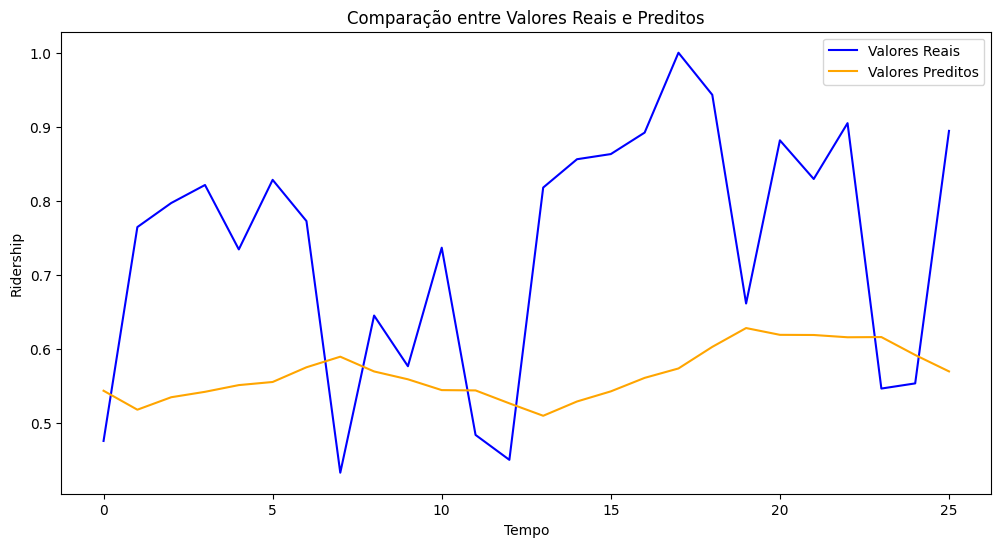

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Valores Preditos', color='orange')
plt.xlabel('Tempo')
plt.ylabel('Ridership')
plt.title('Comparação entre Valores Reais e Preditos')
plt.legend()
plt.show()
